# Exploratory Data Analysis of 2018 ACC Lesion Study 

## Imports

In [ ]:
import numpy as np
import polars as pl 
import pandas as pd 
import bambi as bmb
import arviz as az 
import pymc as pm
import platform
from scipy.ndimage import gaussian_filter1d
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets
from matching_pennies.io.metrics_store import load_metrics
from matching_pennies.analysis.bambi_plots import plot_trace
from matching_pennies.utils import preprocessing, plotting 

## Loading Data from Config 

In [71]:
EXPERIMENT = "2018_acc_lesion"
PARADIGM = "post_sx_testing" 
path = "C:/Users/benli/Documents/code/matching-pennies/data"

tdf_post, sdf_post, manifest = load_metrics(EXPERIMENT, PARADIGM, root=path)

## Cursory Data Exploration

Answer some basic questions: 
1. How many animals are there total 
2. How many trials did each animal complete in each session
3. Does each animal have the same number of sessions? 

### Animals

How many animals are there total? 

In [3]:
n = len(sdf_post["animal_id"].unique())

How many animals in each treatment group? 

In [4]:
group_ids = (
    sdf_post
    .group_by("treatment")
    .agg(
        pl.col("animal_id").unique(),
        pl.col("animal_id").n_unique().alias("n_animals")
    )
)
group_ids

treatment,animal_id,n_animals
cat,list[cat],u32
"""sham""","[""P4023"", ""P4024"", … ""P4037""]",7
"""acc""","[""P4020"", ""P4021"", … ""P4036""]",10
null,"[""P4026""]",1


### Treatment

One animal does not have a treatment group assigned. cut them out of the dataset. 

In [5]:
null_treatment = group_ids.filter(pl.col("treatment").is_null()).get_column("animal_id")[0][0]
null_treatment

'P4026'

In [6]:
sdf_post = sdf_post.filter(pl.col("animal_id") != null_treatment)
tdf_post = tdf_post.filter(pl.col("animal_id") != null_treatment)

null_treatment in sdf_post["animal_id"].unique()

False

Set treatment order to use in plotting later

In [7]:
treat_order = ["sham", "acc"] 
cat = {"treatment": treat_order}

### Number of sessions

In [8]:
num_sessions = sdf_post.group_by(["animal_id"]).agg(pl.col("session_idx").max().alias("num_sessions"))
ses_set = num_sessions["num_sessions"].unique()
ses_set

num_sessions
i32
3


`ses_set` shows that all animals completed 3 sessions.

### Trial Numbers

Next lets look at the minimum, maximum, and mean number of trials 

In [9]:
sdf_post.group_by(["treatment"]).agg(
    pl.col("NumTrials").min().alias("minimum_trials"),
    pl.col("NumTrials").max().alias("maximum_trials"),
    pl.mean("NumTrials").alias("mean_trials"), 
    pl.median("NumTrials").alias("median_trials"),
    pl.std("NumTrials").alias("sd_trials")
)

treatment,minimum_trials,maximum_trials,mean_trials,median_trials,sd_trials
cat,u32,u32,f64,f64,f64
"""acc""",245,453,341.4,338.0,53.827054
"""sham""",199,435,324.666667,329.0,65.232916


Plot a histogram for the number of trials in each session

In [10]:
num_trial = sdf_post.group_by(["animal_id", "treatment"]).agg(pl.mean("NumTrials"))

px.violin(
    num_trial,
    x="treatment",
    y="NumTrials",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Average Number of trials per animal"
)

## Session-Level Group Comparisons

### Percent Correct Choice

In [11]:
correct = sdf_post.group_by(["treatment", "animal_id"]).agg(pl.mean("PercentCorrectChoice")).sort(["treatment", "animal_id"])

In [12]:
px.violin(
    correct, 
    x="treatment",
    y="PercentCorrectChoice",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Proportion of Correct Choice"
)

### Probability of choosing the right side

In [13]:
p_right = sdf_post.group_by(["treatment", "animal_id"]).agg(pl.mean("ProbR")).sort(["treatment", "animal_id"])
p_right

treatment,animal_id,ProbR
cat,cat,f64
"""acc""","""P4020""",0.538616
"""acc""","""P4021""",0.512769
"""acc""","""P4022""",0.502128
"""acc""","""P4025""",0.466472
"""acc""","""P4027""",0.531412
…,…,…
"""sham""","""P4029""",0.543775
"""sham""","""P4031""",0.452427
"""sham""","""P4033""",0.487012


In [14]:
px.violin(
    p_right,
    x="treatment", 
    y="ProbR",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Probability of choosing the feeder on the right side"
)

### Win-Stay and Lose-Switch

ProbWinStay & ProbLoseSwitch

In [15]:
wsls = (
    sdf_post
    .group_by(["animal_id", "treatment"])
    .agg(
        pl.mean("ProbWinStay").alias("mean_ws"),
        pl.mean("ProbLoseSwitch").alias("mean_ls") 
    )
    .sort(["treatment", "animal_id"])
)
wsls

animal_id,treatment,mean_ws,mean_ls
cat,cat,f64,f64
"""P4020""","""acc""",0.634082,0.705811
"""P4021""","""acc""",0.686171,0.713442
"""P4022""","""acc""",0.671392,0.6558
"""P4025""","""acc""",0.52421,0.623593
"""P4027""","""acc""",0.621257,0.666577
…,…,…,…
"""P4029""","""sham""",0.626579,0.596266
"""P4031""","""sham""",0.606957,0.638059
"""P4033""","""sham""",0.582782,0.649954


In [16]:
px.violin(
    wsls,
    x="treatment",
    y="mean_ws",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Mean Win-Stay"
)

In [17]:
px.violin(
    wsls,
    x="treatment",
    y="mean_ls",
    box=True,
    points="all",
    color="treatment",
    category_orders=cat,
    title="Mean Lose-Shift"
)

In [22]:
sdf_post

animal_id,session_idx,treatment,NumTrials,PercentCorrectChoice,MeanRewardsPerTrial,ProbR,ProbWSLS,ProbWinStay,ProbLoseSwitch,ProbLoseStay,ProbNoResp,ProbSame,MeanLicksTotal,MeanLicksBeforeRew
cat,i32,cat,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""P4024""",3,"""sham""",393,0.397959,0.396947,0.478261,0.716113,0.683871,0.740426,0.259574,0.002545,0.533163,11.160237,0.64095
"""P4030""",1,"""acc""",358,0.495798,0.494413,0.52809,0.682584,0.72,0.644444,0.355556,0.002793,0.498599,16.321543,2.26045
"""P4031""",2,"""sham""",370,0.455285,0.451351,0.408719,0.618529,0.560241,0.665,0.335,0.005405,0.482385,6.544248,0.911504
"""P4020""",2,"""acc""",272,0.483395,0.474265,0.541045,0.64794,0.6015625,0.688406,0.311594,0.011029,0.498155,11.91453,1.286325
"""P4035""",1,"""acc""",376,0.409574,0.406915,0.47861,0.695187,0.596026,0.761261,0.238739,0.00266,0.52,9.383099,1.157746
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""P4037""",2,"""sham""",322,0.498442,0.496894,0.521875,0.571875,0.503145,0.6375,0.3625,0.003106,0.433022,10.442379,0.743494
"""P4022""",2,"""acc""",350,0.501433,0.497143,0.492795,0.67341,0.686047,0.65896,0.34104,0.005714,0.489971,15.503067,1.607362
"""P4024""",1,"""sham""",395,0.461929,0.458228,0.464286,0.649616,0.616667,0.67619,0.32381,0.005063,0.538071,7.846473,0.618257


### Licking 

In [23]:
plotting.plot_session_mean(sdf_post, "MeanLicksTotal", cat, title="Mean Licks Total")

In [24]:
plotting.plot_session_mean(sdf_post, "MeanLicksBeforeRew", cat, title="Mean Licks Before Reward")

## Binned Trial Group Comparisons

Truncate Data to minimum session extent

In [32]:
tdf_trunc = preprocessing.clip_to_minimum_extent(tdf_post, "trial_idx", groupby=("animal_id", "session_idx"))

Bin trial DataFrame on trial numbers 

In [35]:
tdf_trunc = preprocessing.bin_data(tdf_trunc, 20)

Plot behavioural measures

### WSLS

In [36]:
ls_bin = plotting.bin_and_aggregate_flag(tdf_trunc, "LoseSwitch_NoMultWellResp_flg")
plotting.line_by_treatment_across_bins(
    ls_bin,
    x="bin",
    y="LoseSwitch_NoMultWellResp_flg_fraction",
    category_orders=cat
)

In [37]:
ws_bin = plotting.bin_and_aggregate_flag(tdf_trunc, "WinStay_NoMultWellResp_flg")
plotting.line_by_treatment_across_bins(
    ws_bin,
    x="bin",
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat
)

### EFS

In [39]:
efs_bin = plotting.bin_and_aggregate_flag(tdf_trunc, "EFS_before_flg")
plotting.line_by_treatment_across_bins(
    efs_bin,
    x="bin",
    y="EFS_before_flg_fraction",
    category_orders=cat 
)

### Licking

Licks before reward

In [40]:
from matching_pennies.utils.search_cols import search_cols
search_cols("lick", tdf_trunc)

['L_lick_ts',
 'R_lick_ts',
 'L_clicks',
 'R_clicks',
 'n_L_licks',
 'n_R_licks',
 'LicksTotal',
 'LicksBeforeRew']

In [42]:
lbr_bin = plotting.bin_and_aggregate_flag(tdf_trunc, "LicksBeforeRew")
plotting.line_by_treatment_across_bins(
    lbr_bin,
    x="bin",
    y="LicksBeforeRew_fraction"
)

In [43]:
lt_bin = plotting.bin_and_aggregate_flag(tdf_trunc, "LicksTotal")
plotting.line_by_treatment_across_bins(
    lt_bin,
    x="bin",
    y="LicksTotal_fraction"
)

## GLMM analysis

Scale trial and session indices to help with convergence

In [61]:
tdf_post = preprocessing.scale_col(tdf_post, "trial_idx")
tdf_post = preprocessing.scale_col(tdf_post, "session_idx") 

req_cols = ["treatment", "animal_id", "trial_idx_scaled", "session_idx_scaled", "EFS_before_flg"]

# Convert to pandas because bambi is lame 
df = tdf_post[req_cols].to_pandas()
df = df.dropna()

# Add Categorical levels 
df["treatment"] = pd.Categorical(df["treatment"], categories=["sham", "acc"], ordered=True)

In [62]:
efs_formula = "EFS_before_flg ~ treatment*trial_idx_scaled + treatment*session_idx_scaled + (1|animal_id)"
efs_model = bmb.Model(
    efs_formula,
    df,
    family="bernoulli"
)
idata_efs = efs_model.fit(idata_kwargs={"log_likelihood": True})

Modeling the probability that EFS_before_flg==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, trial_idx_scaled, treatment:trial_idx_scaled, session_idx_scaled, treatment:session_idx_scaled, 1|animal_id_sigma, 1|animal_id_offset]


c:\Users\benli\Documents\code\matching-pennies\.venv\Lib\site-packages\rich\live.py:256: UserWarning:

install "ipywidgets" for Jupyter support

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


Summarize the simulation results

In [63]:
az.summary(idata_efs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.610,0.205,-1.998,-1.232,0.006,0.004,1240.0,1515.0,1.0
treatment[acc],-0.302,0.263,-0.781,0.231,0.008,0.006,1123.0,1603.0,1.0
trial_idx_scaled,-0.211,0.159,-0.513,0.087,0.003,0.003,2789.0,2523.0,1.0
treatment:trial_idx_scaled[acc],0.445,0.197,0.075,0.819,0.004,0.003,2816.0,2554.0,1.0
session_idx_scaled,-0.329,0.087,-0.490,-0.168,0.002,0.001,2750.0,2416.0,1.0
treatment:session_idx_scaled[acc],0.583,0.109,0.366,0.773,0.002,0.002,2983.0,2744.0,1.0
1|animal_id_sigma,0.500,0.103,0.326,0.696,0.003,0.003,1040.0,1318.0,1.0
1|animal_id[P4020],-0.065,0.182,-0.436,0.248,0.006,0.004,1038.0,1846.0,1.0
1|animal_id[P4021],-0.513,0.186,-0.857,-0.166,0.005,0.003,1226.0,1975.0,1.0
1|animal_id[P4022],-0.220,0.182,-0.535,0.134,0.006,0.004,1006.0,1564.0,1.0


C:\Users\benli\Documents\code\matching-pennies\matching_pennies\analysis\bambi_plots.py:83: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



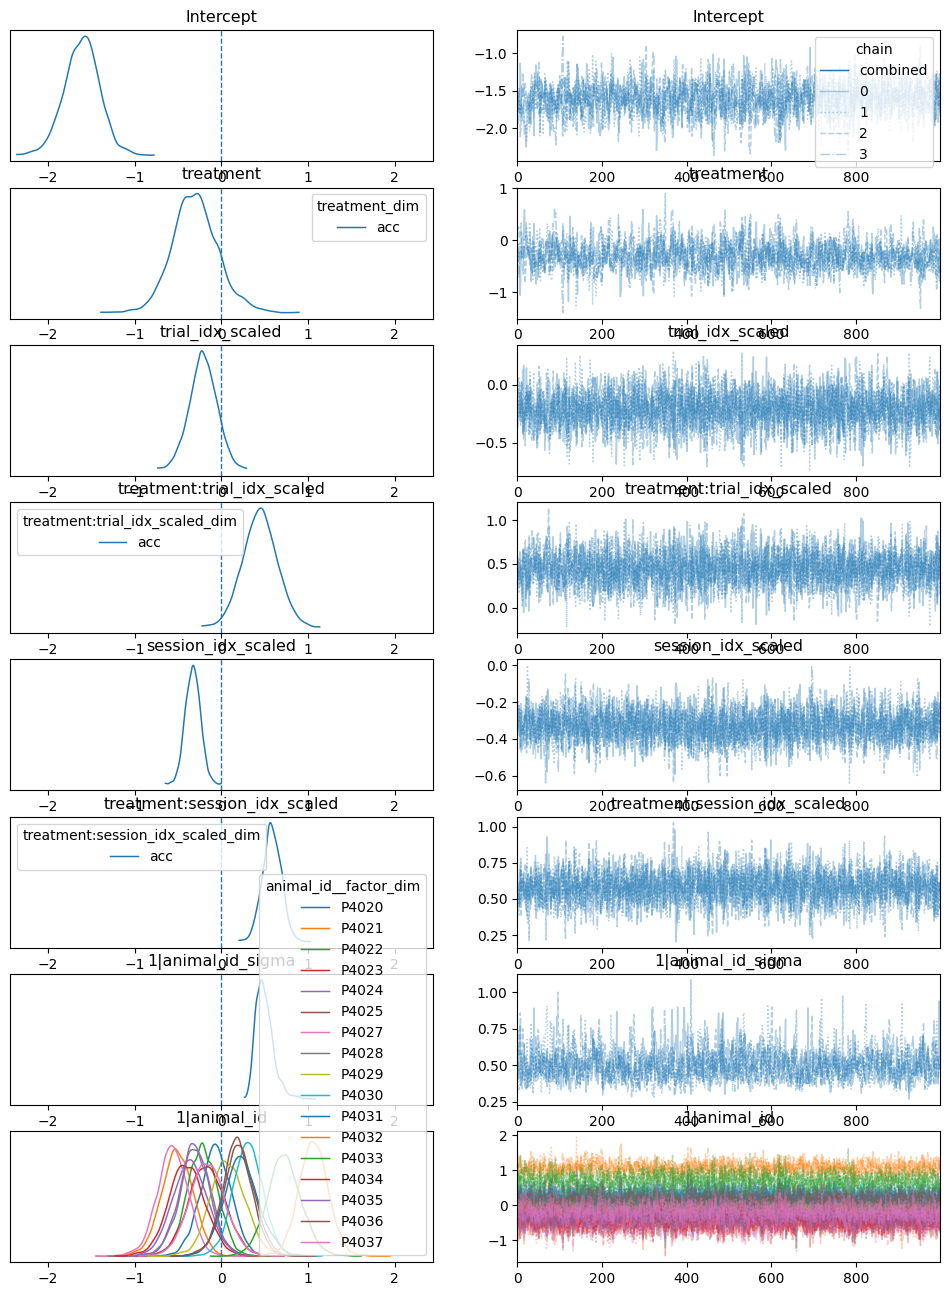

In [65]:
fig, ax = plot_trace(idata_efs, compact=True)
plt.show()

Do Posterior predictive checks 

c:\Users\benli\Documents\code\matching-pennies\.venv\Lib\site-packages\bambi\models.py:850: FutureWarning:

'pps' has been replaced by 'response' and is not going to work in the future



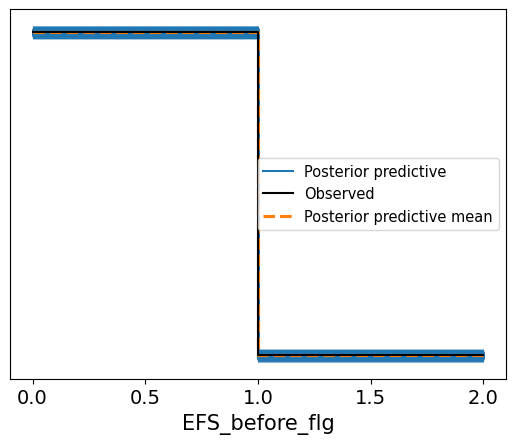

<Axes: xlabel='EFS_before_flg'>

In [66]:
ppc = efs_model.predict(
    idata_efs,
    kind="pps",
    inplace=False
)
az.plot_ppc(ppc, show=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

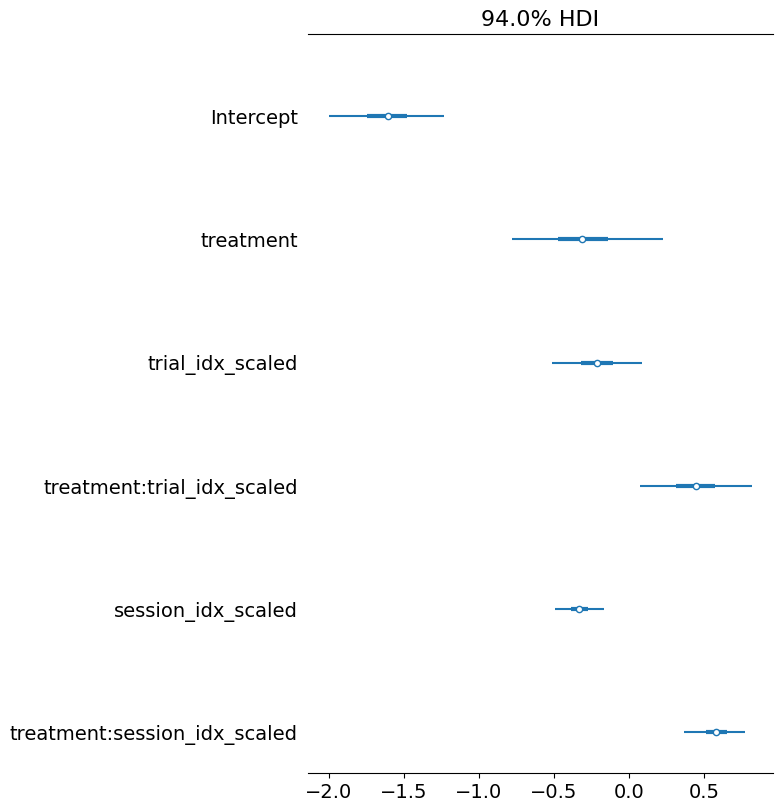

In [70]:
plot_vars = ["Intercept", "treatment", 
             "trial_idx_scaled", "treatment:trial_idx_scaled", 
             "session_idx_scaled", "treatment:session_idx_scaled"]
az.plot_forest(idata_efs, var_names=plot_vars, combined=True)

## Compare with last days of training

### Load Training Data

In [88]:
TRAINING_PARADIGM = "training" 

tdf_train, sdf_train, manifest_train = load_metrics(EXPERIMENT, TRAINING_PARADIGM, root=path)

### Make sure everything is kosher

In [89]:
sdf_train.group_by("animal_id").agg(pl.max("session_idx")).select(pl.col("session_idx").unique())

session_idx
i32
7


All animals have the same number of sessions. Cool. 

Remove rows where the animal is not assigned a treatment 

In [90]:
no_treat = sdf_train.filter(pl.col("treatment").is_null()).select(pl.col("animal_id")).unique().item()
sdf_train = sdf_train.filter(pl.col("animal_id") != no_treat)

### Basic visualizations

Lets see how the number of trials increases over training

In [95]:
mean_trials = sdf_train.group_by(["treatment", "session_idx"]).agg(pl.mean("NumTrials")).sort(["treatment", "session_idx"])
mean_trials

treatment,session_idx,NumTrials
cat,i32,f64
"""acc""",1,96.7
"""acc""",2,216.1
"""acc""",3,225.6
"""acc""",4,204.0
"""acc""",5,232.9
…,…,…
"""sham""",3,223.0
"""sham""",4,225.0
"""sham""",5,248.428571


In [97]:
px.line(
    mean_trials,
    x="session_idx",
    y="NumTrials",
    color="treatment",
    category_orders=cat
)

# TODO

- Look at hallway switching behaviour
    - Any differences between sham and acc? 

- Analyze old OFC lesion data